# Bike Routes in Denver

In this notebook, we load the bike routes of Denver.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import geonetworkx as gnx
import momepy # Used to build networks from GDF
import matplotlib.pyplot as plt

C:\Users\17347\Documents\Anaconda\envs\geo_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
lanes = gpd.read_file("BS_lanes.geojson")
streets = gpd.read_file("BS_streets.geojson")
trails = gpd.read_file("BS_trails.geojson")

<AxesSubplot:>

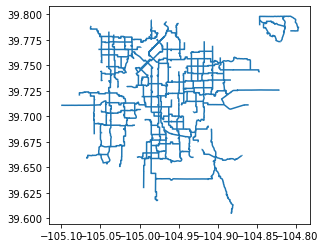

In [4]:
streets.plot()

In [5]:
bike_fac = gpd.read_file("existing_denver_bike_facilities.shp")

<Figure size 3600x3600 with 0 Axes>

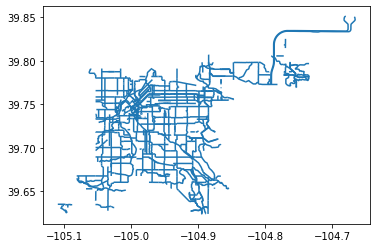

In [6]:
plt.figure(1,figsize=(50,50))
bike_fac.plot()
plt.show()

In [24]:
len(bike_fac)

827

In [8]:
bike_shared_road = bike_fac[bike_fac["EXISTING_F"] == 'Shared Roadway']
bike_unpro_BL = bike_fac[bike_fac["EXISTING_F"] == 'Bike Lane']
bike_pro_BL = pd.concat([bike_fac[bike_fac["EXISTING_F"] == 'Buffered Bike Lane'], 
                         bike_fac[bike_fac["EXISTING_F"] == 'Shared Bike Lane']])
bike_path = pd.concat([bike_fac[bike_fac["EXISTING_F"] == 'Shared Use Path'], 
                       bike_fac[bike_fac["EXISTING_F"] == 'Neighborhood Bikeway']])

<AxesSubplot:>

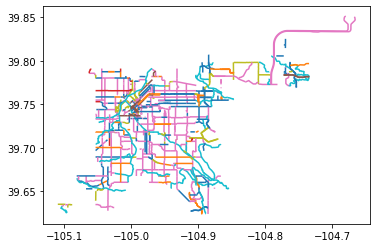

In [9]:
bike_fac.plot("EXISTING_F")

In [10]:
bike_fac_path_cat = pd.Categorical(bike_fac['EXISTING_F'])
bike_fac_path_cat
bike_fac['path_codes'] = bike_fac_path_cat.codes

Getting Distances of Paths in Meters

In [11]:
lines_bike_fac = bike_fac.explode(index_parts=True)

In [12]:
np.set_printoptions(suppress=True)
dist = list(lines_bike_fac.to_crs(3763).length)
dist = np.array(dist)
dist = dist.round(decimals = 2)
# dist

In [13]:
lines_bike_fac['lengths'] = dist

C:\Users\17347\Documents\Anaconda\envs\geo_env\lib\site-packages\momepy\utils.py:235: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


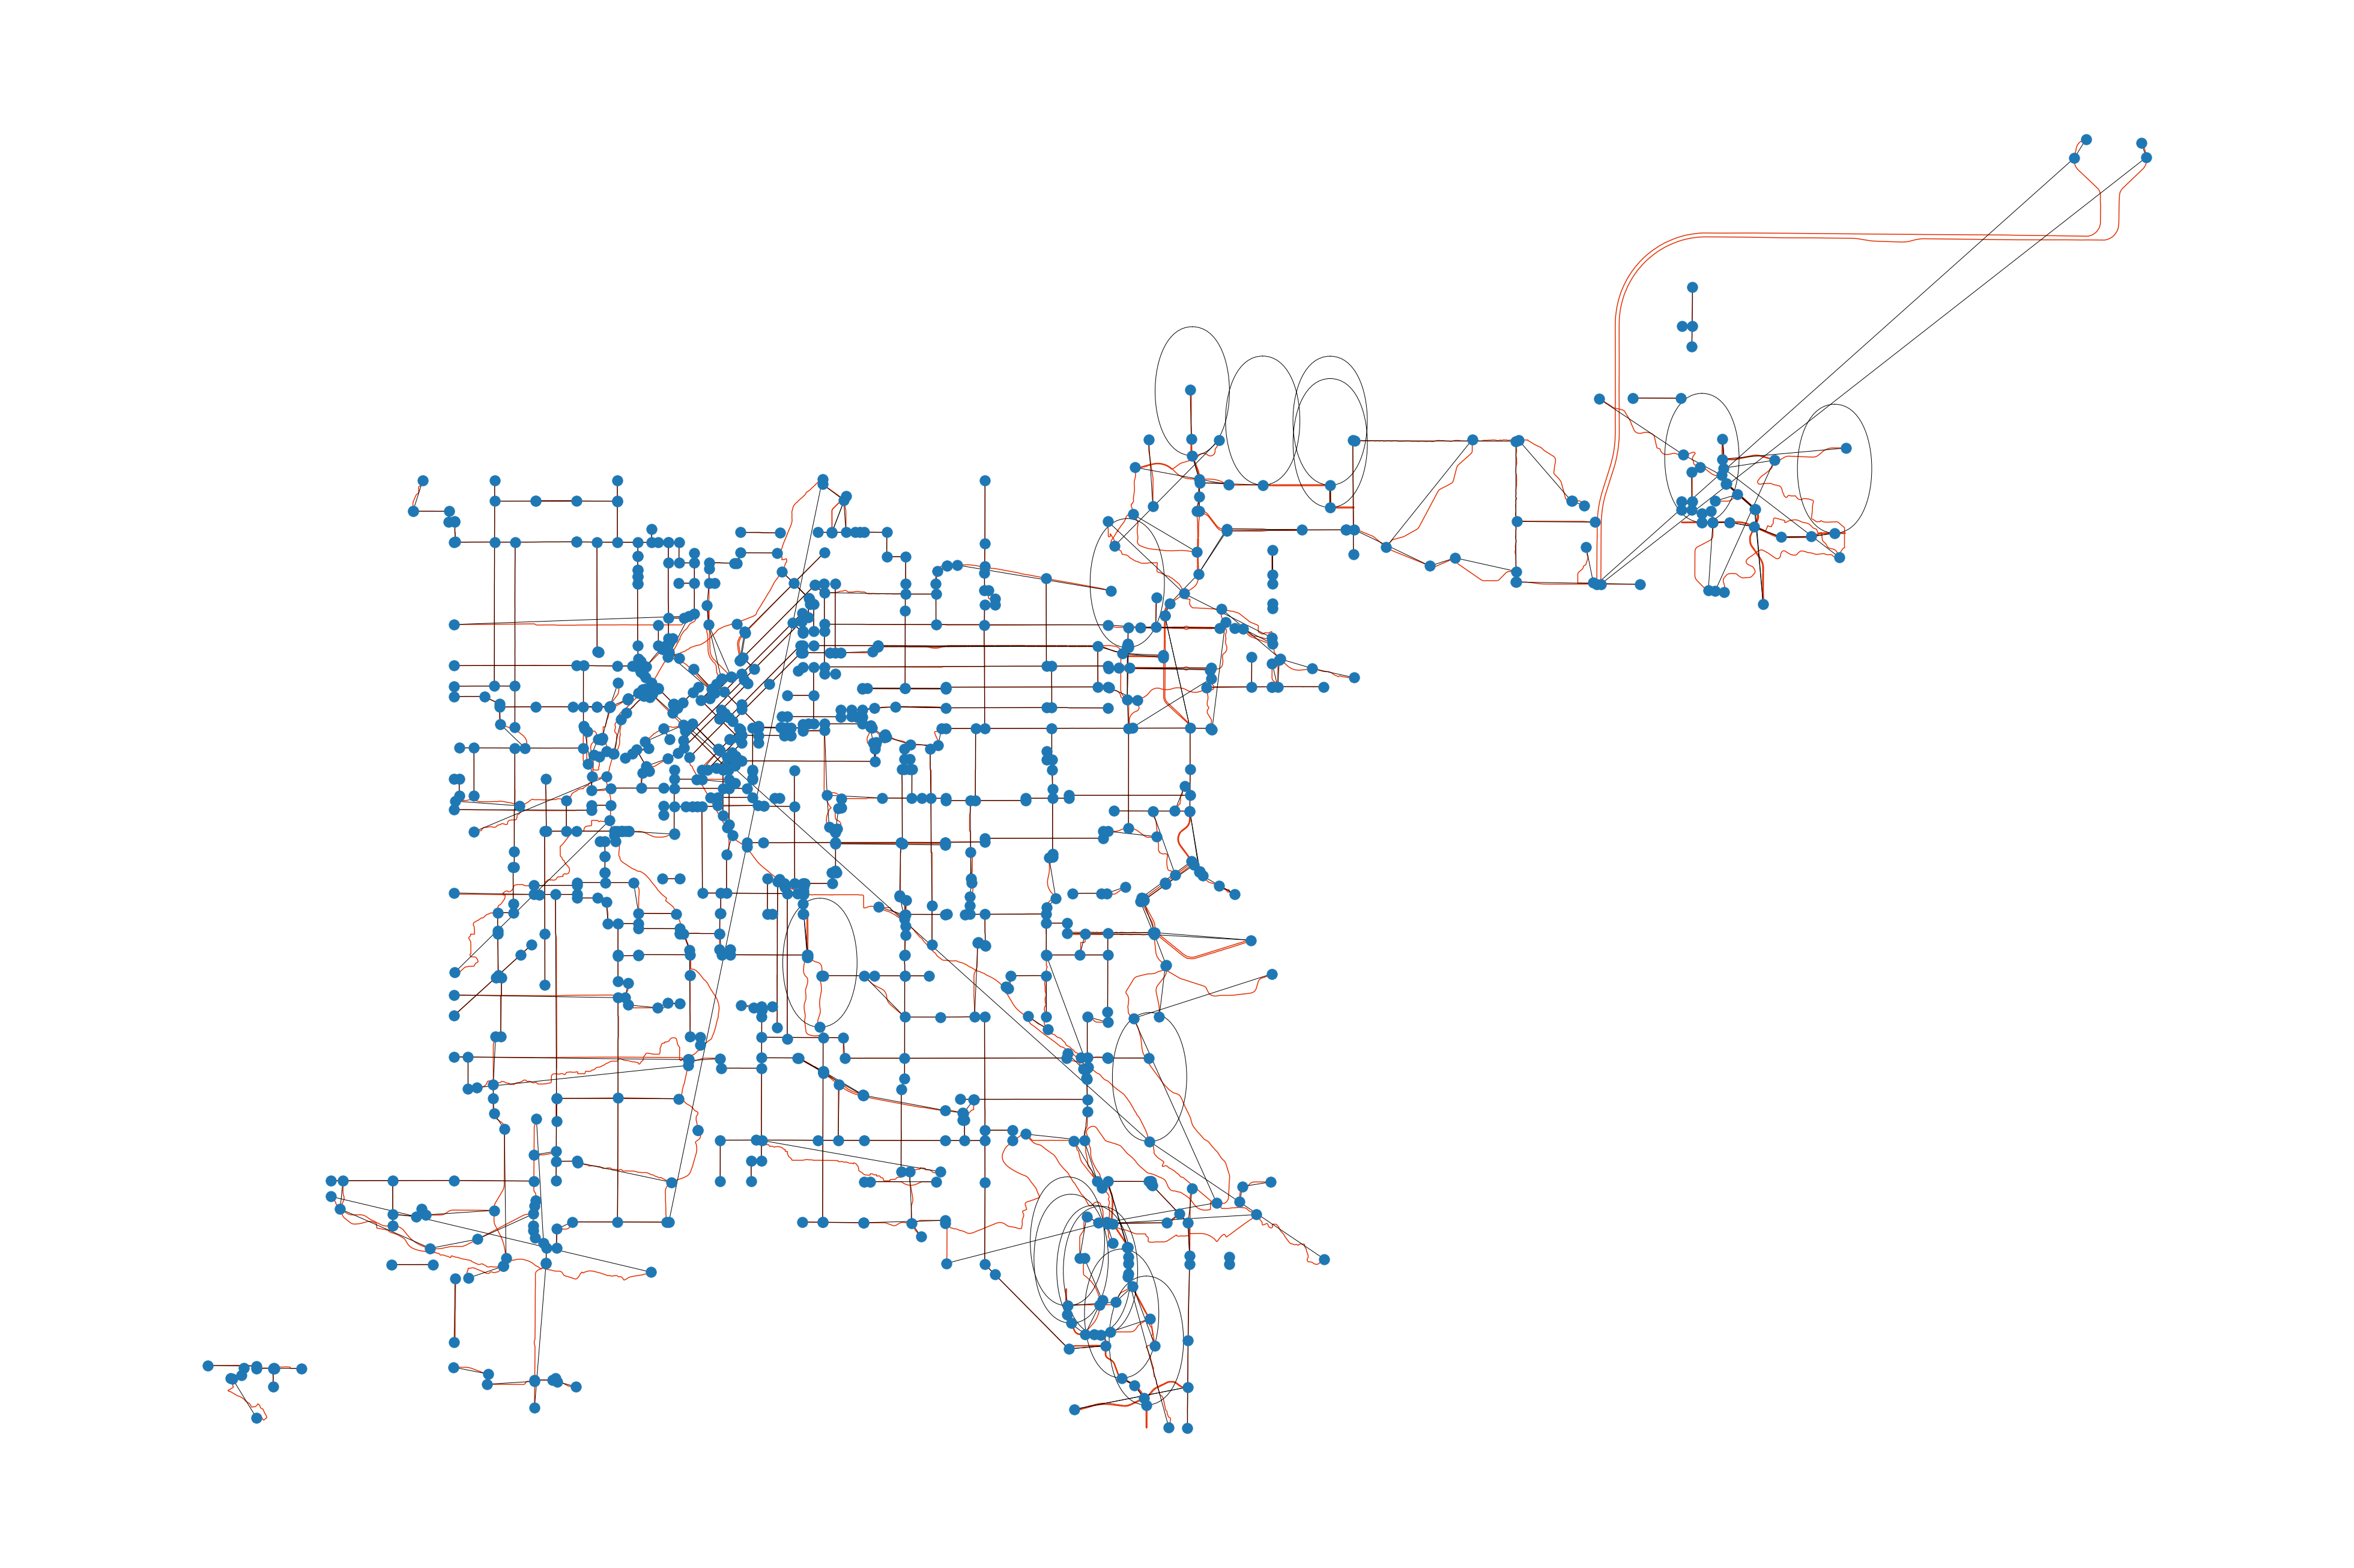

In [23]:
f, ax = plt.subplots(1, 1, figsize=(70, 70), sharex=True, sharey=True)

g_primal = momepy.gdf_to_nx(lines_bike_fac, approach = 'primal')
positions = {n: [n[0], n[1]] for n in list(g_primal.nodes)}
plt.figure(1,figsize=(50,50))
lines_bike_fac.plot(color='#e32e00',ax=ax, zorder=-1)
nx.draw(g_primal,positions)
plt.show()

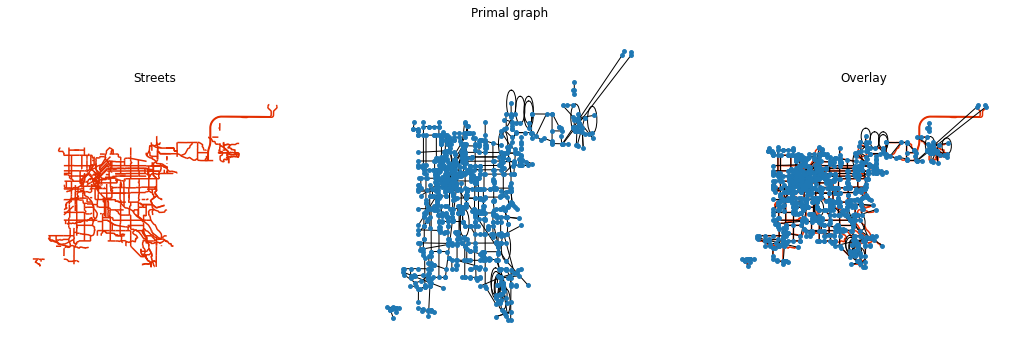

In [22]:
f, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
lines_bike_fac.plot(color='#e32e00', ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Primal graph", "Overlay")[i])
    facet.axis("off")
nx.draw(g_primal, {n:[n[0], n[1]] for n in list(g_primal.nodes)}, ax=ax[1], node_size=15)
lines_bike_fac.plot(color='#e32e00', ax=ax[2], zorder=-1)
nx.draw(g_primal, {n:[n[0], n[1]] for n in list(g_primal.nodes)}, ax=ax[2], node_size=15)

In [16]:
multi = 0
for i in bike_fac.index:
    geom = bike_fac['geometry'][i]
    if geom.geom_type=='MultiLineString':
#         print(type(geom))
#         print(geom)
        break
        multi += 1
# multi

In [17]:
multi_explosion = multi_bike_fac.explode(index_parts=True)

NameError: name 'multi_bike_fac' is not defined

Relabelling nodes and edges

In [31]:
mapping = dict(zip(g_primal, range(1, len(list(g_primal.nodes))+1)))
G_labels = nx.relabel_nodes(g_primal, mapping)

networkx.classes.multigraph.MultiGraph

In [26]:
# current format is "tail, head, edge label"
edges = np.array(list(G_labels.edges))

Get path category and distance data from each edge

In [27]:
lengths = []
path_cat = []
for i in range(len(edges)):
    lengths.append(G_labels.get_edge_data(edges[i,0],edges[i,1]).get(edges[i,2]).get('lengths'))
    path_cat.append(G_labels.get_edge_data(edges[i,0],edges[i,1]).get(edges[i,2]).get('path_codes'))

combine edge data into sinlg np.array

In [28]:
add_dists = np.concatenate((edges[:,:2], np.array(lengths).reshape(len(lengths),1)), 1)
all_edge_data = np.concatenate((add_dists, np.array(path_cat).reshape(len(path_cat),1)), 1)
all_edge_data

array([[   1.  ,    2.  , 1105.85,    4.  ],
       [   1.  ,   46.  ,  372.7 ,    4.  ],
       [   3.  ,    4.  ,  353.07,    4.  ],
       ...,
       [1110.  , 1112.  ,  468.6 ,    2.  ],
       [1113.  , 1113.  ,  568.98,    1.  ],
       [1113.  , 1114.  , 1919.15,    1.  ]])

Put node labels in np.array

In [29]:
nodes = np.array(list(G_labels.nodes))
nodes

array([   1,    2,    3, ..., 1112, 1113, 1114])

**New Edge Data Node Correction**

In [2]:
edge_data = pd.read_csv ('cleaned_edges.csv')

In [3]:
edge_data.columns
edge_data = edge_data.rename(columns={'my_edges.from': 'tail', 'my_edges.to': 'head','my_edges.EXISTING_F': 'existing_f', 'my_edges.FULLNAME': 'fullname','my_edges.FROMNAME': 'fromname', 'my_edges.TONAME': 'toname'})
edge_data['tail']-=1
edge_data['head']-=1

In [6]:
edge_data['existing_f'] = edge_data['existing_f'].fillna('Shared Use Path')

In [7]:
edge_data

,tail,head,existing_f,fullname,fromname,toname
0,0,1,Shared Roadway,E 45TH AVE,N WASHINGTON ST,N BROADWAY/W 44TH AVE
1,3,4,Bike Lane,W 17TH AVE,W LAKESHORE DR/N NEWTON ST,N ZENOBIA ST
2,4,5,Bike Lane,W 17TH AVE,W LAKESHORE DR/N NEWTON ST,N ZENOBIA ST
3,5,6,Bike Lane,W 17TH AVE,W LAKESHORE DR/N NEWTON ST,N ZENOBIA ST
4,7,8,Bike Lane,S YOSEMITE ST,S YOSEMITE ST,PRIVATE RD
...,...,...,...,...,...,...
1240,958,1020,Shared Use Path,NaN,NaN,NaN
1241,265,783,Shared Use Path,NaN,NaN,NaN
1242,1035,409,Shared Use Path,NaN,NaN,NaN
1243,765,668,Shared Use Path,NaN,NaN,NaN


In [8]:
node_data = pd.read_csv('cleaned_coords.csv')

In [9]:
nodes = pd.DataFrame(np.array(range(0,len(node_data))))
node_data['node'] = nodes
# node_data

In [10]:
from shapely.geometry import Point
from shapely.geometry import LineString
startlat = []
endlat=[]
startlong=[]
endlong=[]
for i in range(0, len(edge_data)):
    startlat.append(node_data['X'][edge_data['tail'][i]])
    startlong.append(node_data['Y'][edge_data['tail'][i]])
    endlat.append(node_data['X'][edge_data['head'][i]])
    endlong.append(node_data['Y'][edge_data['head'][i]])

start = [Point(xy) for xy in zip(startlat, startlong)]    
end = [Point(xy) for xy in zip(endlat, endlong)] 
edge_data['start'] = start
edge_data['end'] = end

C:\Users\17347\Documents\Anaconda\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\17347\Documents\Anaconda\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [11]:
edge_data['line'] = edge_data.apply(lambda row: LineString([row['start'], row['end']]), axis=1) #Create a linestring column

# # Zip the coordinates into a point object and convert to a GeoDataFrame
# geometry = [Point(xy) for xy in zip(startlong, startlat)]
# df = GeoDataFrame(edge_data, geometry=geometry)

# # Aggregate these points with the GroupBy
# df = df.groupby(['entity_id'])['geometry'].apply(lambda x: LineString(x.tolist()))
# df = GeoDataFrame(df, geometry='geometry')

C:\Users\17347\Documents\Anaconda\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [12]:
edge_data_geo = gpd.GeoDataFrame(edge_data, geometry='line')
edge_data_geo.crs = "EPSG:4326"
edge_data

,tail,head,existing_f,fullname,fromname,toname,start,end,line
0,0,1,Shared Roadway,E 45TH AVE,N WASHINGTON ST,N BROADWAY/W 44TH AVE,POINT (-104.9876 39.7783),POINT (-104.9792 39.7783),"LINESTRING (-104.98760 39.77830, -104.97920 39..."
1,3,4,Bike Lane,W 17TH AVE,W LAKESHORE DR/N NEWTON ST,N ZENOBIA ST,POINT (-105.037 39.744),POINT (-105.0393 39.744),"LINESTRING (-105.03700 39.74400, -105.03930 39..."
2,4,5,Bike Lane,W 17TH AVE,W LAKESHORE DR/N NEWTON ST,N ZENOBIA ST,POINT (-105.0393 39.744),POINT (-105.0487 39.744),"LINESTRING (-105.03930 39.74400, -105.04870 39..."
3,5,6,Bike Lane,W 17TH AVE,W LAKESHORE DR/N NEWTON ST,N ZENOBIA ST,POINT (-105.0487 39.744),POINT (-105.0521 39.744),"LINESTRING (-105.04870 39.74400, -105.05210 39..."
4,7,8,Bike Lane,S YOSEMITE ST,S YOSEMITE ST,PRIVATE RD,POINT (-104.884874999584 39.6599500000938),POINT (-104.8848 39.6572),"LINESTRING (-104.88487 39.65995, -104.88480 39..."
...,...,...,...,...,...,...,...,...,...
1240,958,1020,Shared Use Path,NaN,NaN,NaN,POINT (-104.865349999891 39.7608500000107),POINT (-104.8567 39.758),"LINESTRING (-104.86535 39.76085, -104.85670 39..."
1241,265,783,Shared Use Path,NaN,NaN,NaN,POINT (-104.9054 39.6459),POINT (-104.8978 39.6491),"LINESTRING (-104.90540 39.64590, -104.89780 39..."
1242,1035,409,Shared Use Path,NaN,NaN,NaN,POINT (-104.9921 39.7439),POINT (-104.9889 39.7464),"LINESTRING (-104.99210 39.74390, -104.98890 39..."
1243,765,668,Shared Use Path,NaN,NaN,NaN,POINT (-105.0028 39.7369),POINT (-105.0104 39.7369),"LINESTRING (-105.00280 39.73690, -105.01040 39..."


In [13]:
np.set_printoptions(suppress=True)
dist = list(edge_data_geo.to_crs(3763).length)
dist = np.array(dist)
dist = dist.round(decimals = 2)
dist

array([1110.51,  304.38, 1243.97, ...,  602.57, 1006.12,  829.88])

In [24]:
bike_fac_path_cat = pd.Categorical(edge_data['existing_f'])
print(bike_fac_path_cat)
edge_data['path_codes'] = bike_fac_path_cat.codes
edge_data['dist'] = dist
edge_data

['Shared Roadway', 'Bike Lane', 'Bike Lane', 'Bike Lane', 'Bike Lane', ..., 'Shared Use Path', 'Shared Use Path', 'Shared Use Path', 'Shared Use Path', 'Shared Use Path']
Length: 1245
Categories (7, object): ['Bike Lane', 'Buffered Bike Lane', 'Neighborhood Bikeway', 'Protected Bike Lane', 'Shared Roadway', 'Shared Use Path', 'Trail']


,tail,head,existing_f,fullname,fromname,toname,start,end,line,path_codes,dist
0,0,1,Shared Roadway,E 45TH AVE,N WASHINGTON ST,N BROADWAY/W 44TH AVE,POINT (-104.9876 39.7783),POINT (-104.9792 39.7783),"LINESTRING (-104.98760 39.77830, -104.97920 39...",4,1110.51
1,3,4,Bike Lane,W 17TH AVE,W LAKESHORE DR/N NEWTON ST,N ZENOBIA ST,POINT (-105.037 39.744),POINT (-105.0393 39.744),"LINESTRING (-105.03700 39.74400, -105.03930 39...",0,304.38
2,4,5,Bike Lane,W 17TH AVE,W LAKESHORE DR/N NEWTON ST,N ZENOBIA ST,POINT (-105.0393 39.744),POINT (-105.0487 39.744),"LINESTRING (-105.03930 39.74400, -105.04870 39...",0,1243.97
3,5,6,Bike Lane,W 17TH AVE,W LAKESHORE DR/N NEWTON ST,N ZENOBIA ST,POINT (-105.0487 39.744),POINT (-105.0521 39.744),"LINESTRING (-105.04870 39.74400, -105.05210 39...",0,449.94
4,7,8,Bike Lane,S YOSEMITE ST,S YOSEMITE ST,PRIVATE RD,POINT (-104.884874999584 39.6599500000938),POINT (-104.8848 39.6572),"LINESTRING (-104.88487 39.65995, -104.88480 39...",0,472.55
...,...,...,...,...,...,...,...,...,...,...,...
1240,958,1020,Shared Use Path,NaN,NaN,NaN,POINT (-104.865349999891 39.7608500000107),POINT (-104.8567 39.758),"LINESTRING (-104.86535 39.76085, -104.85670 39...",5,1244.65
1241,265,783,Shared Use Path,NaN,NaN,NaN,POINT (-104.9054 39.6459),POINT (-104.8978 39.6491),"LINESTRING (-104.90540 39.64590, -104.89780 39...",5,1149.55
1242,1035,409,Shared Use Path,NaN,NaN,NaN,POINT (-104.9921 39.7439),POINT (-104.9889 39.7464),"LINESTRING (-104.99210 39.74390, -104.98890 39...",5,602.57
1243,765,668,Shared Use Path,NaN,NaN,NaN,POINT (-105.0028 39.7369),POINT (-105.0104 39.7369),"LINESTRING (-105.00280 39.73690, -105.01040 39...",5,1006.12


In [20]:
final_edge_data = []
final_edge_data = pd.DataFrame(final_edge_data)
final_edge_data['tail'] = edge_data['tail']
final_edge_data['head'] = edge_data['head']
final_edge_data['dist'] = edge_data['dist']
final_edge_data['path_code'] = edge_data['path_codes']

In [21]:
final_edge_data

,tail,head,dist,path_code
0,0,1,1110.51,4
1,3,4,304.38,0
2,4,5,1243.97,0
3,5,6,449.94,0
4,7,8,472.55,0
...,...,...,...,...
1240,958,1020,1244.65,5
1241,265,783,1149.55,5
1242,1035,409,602.57,5
1243,765,668,1006.12,5


Save to CSV

In [22]:
final_edge_data.to_csv("edge_data_updated.csv")

In [16]:
nodes.to_csv("node_data_updated.csv")

In [126]:
# edgesdf = pd.DataFrame(all_edge_data)
# nodesdf = pd.DataFrame(nodes)
  
# # save the dataframe as a csv file
# edgesdf.to_csv("edge_data.csv")
# nodesdf.to_csv("node_data.csv")